# Simulated charge stability diagrams for a 2x2 quantum dot system

This example shows how to use `qtt.simulation.dotsystem` to define a Hubbard-based model system of a 4 quantum dot array in a 2x2 plaquette configuration. Here we will use this model system to reproduce the Fig 1c plot from https://aip.scitation.org/doi/10.1063/1.5025928 

In [1]:
%matplotlib inline
import qtt.simulation.dotsystem as dotsystem
import matplotlib.pyplot as plt
import numpy as np

Define some extra helper functions

In [2]:
def gatesfromdet(ds, dvals=None):
    ''' After manually setting det variables, run this function to set the correct gate values '''
    setgates = False
    if dvals is None:
        dvals = [getattr(ds, 'det%d' % (i+1)) for i in range(ds.ndots)]
        setgates = True
    gates = np.dot(np.linalg.inv(ds.la_mat),dvals)
    if setgates:
        for i in range(ds.ndots):
            setattr(ds, 'P%d' % (i+1), gates[i])
    return gates

def detfromgates(ds, pvals=None):
    ''' After manually setting gates, run this function to set the correct det values that match that gate combination '''
    setdets = False
    if pvals is None:
        pvals = np.array([getattr(ds, 'P%d' % (i+1)) for i in range(ds.ndots)])
        setdets = True
    dets = np.dot(ds.la_mat,pvals)
    if setdets:
        for i in range(ds.ndots):
            setattr(ds, 'det%d' % (i+1), dets[i])
    return dets

def parsescanparams(ds, nx, ny):
    '''Used for to parse the input to the simulate_honeycomb function'''
    minmax = [[],[]]
    minmax[0] = [-ds.scanrange/2,ds.scanrange/2,-ds.scanrange/2,ds.scanrange/2]
    minmax[1] = [-ds.scanrange/2,-ds.scanrange/2,ds.scanrange/2,ds.scanrange/2]
    ds.makeparamvalues2D(ds.scanparams,minmax,nx,ny)
    if ds.scanparams[0].startswith('det'):
        for pn in ds.scanparams:
            ds.vals2D[pn] += getattr(ds,pn)
            params = ds.vals2D.copy()
    else:
        initvals = ds.getall('det')
        det = []
        for i in range(ds.ndots):
           det.append(np.zeros(ds.vals2D[ds.scanparams[0]].shape))
        params = ds.vals2D.copy()
        dict_params = {}
        for name in ds.scanparams:
            if '{' in name:
                dict_prop = eval(name)
                for name2, prop in dict_prop.items():
                    dict_params[name2] = getattr(ds, name2) + params[name] * prop
            else: 
                dict_params[name] = getattr(ds, name) + params[name]        
        for i in range(nx):
            for j in range(ny):
                for pn, pv in dict_params.items():
                    setattr(ds, pn, pv[i,j])
                det_temp = detfromgates(ds)
                for k in range(len(det_temp)):
                    det[k][i,j] = det_temp[k]
        ds.setall('det',initvals)
        gatesfromdet(ds)
        ds.vals2D = {}
        for i in range(len(det)):
            ds.vals2D['det%i' % (i + 1)] = det[i]
    return params

def clickOCC(ds, params, n=1):
    '''Shows the charge occupation at the points clicked in the plotted charge stability diagram'''
    for i in range(n):
        coords = plt.ginput()
        npoints = np.array([np.shape(params[ds.scanparams[0]])[0], np.shape(params[ds.scanparams[0]])[1]])
        mVranges = np.array([params[ds.scanparams[0]][0,-1] - params[ds.scanparams[0]][0,0], params[ds.scanparams[1]][-1,0] - params[ds.scanparams[1]][0,0]])
        mVs = np.array([coords[0][0] - params[ds.scanparams[0]][0,0], coords[0][1] - params[ds.scanparams[1]][0,0]])
        inds = mVs*npoints/mVranges
        occ = ds.hcgs[int(inds[1]),int(inds[0])]
        plt.text(coords[0][0],coords[0][1],str(occ))

## Initialize the model system with the experimental parameters

In [3]:
tbt = dotsystem.TwoXTwo()

# Cross-capacitance matrix and lever arms
#                     P1     P2     P3    P4
cc_mat = np.array([[ 1.  ,  0.45,  0.54,  0.87],  #Dot 1
                   [ 0.65,  1.  ,  0.47,  0.50],  #Dot 2
                   [ 0.17,  0.47,  1.  ,  0.24],  #Dot 3
                   [ 0.44,  0.35,  0.88,  1.  ]]) #Dot 4
det_to_P = np.array([0.039*np.ones(4), 0.041*np.ones(4), 0.054*np.ones(4), 0.031*np.ones(4)]) #meV/mV
tbt.la_mat = cc_mat * det_to_P

# All the following values in meV
# On-site interaction per dot
tbt.osC1 = 2.5
tbt.osC2 = 2.3
tbt.osC3 = 3
tbt.osC4 = 1.8

# Intersite interaction per pairs of dots
tbt.isC1 = 0.47 # 1-2
tbt.isC2 = 0.35 # 2-3
tbt.isC3 = 0.43 # 3-4
tbt.isC4 = 0.30 # 4-1
tbt.isC5 = 0.28 # 1-3
tbt.isC6 = 0.18 # 2-4

# Tunnel coupling per pairs of dots
tbt.tun1 = 0.02 # 1-2
tbt.tun2 = 0.02 # 2-3
tbt.tun3 = 0.02 # 3-4
tbt.tun4 = 0.02 # 4-1

# Energy offsets per dot (0 is the boundary for adding 1 electron)
tbt.det1 = 1
tbt.det2 = 1
tbt.det3 = 0
tbt.det4 = 0

gates = gatesfromdet(tbt) # This adds the gate voltages (tbt.P#, in mV) that result in the above detuning
print('Current gate voltages: P1=%.2f mV, P2=%.2f mV, P3=%.2f mV, P4=%.2f mV' % tuple(gates))

Current gate voltages: P1=35.83 mV, P2=11.19 mV, P3=-8.40 mV, P4=-12.29 mV


## Run a 2D gate scan simulation and plot the charge stability diagram

simulatehoneycomb: 11.36 [s]


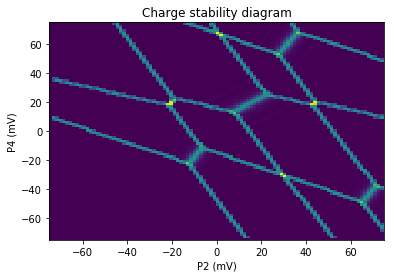

In [4]:
tbt.scanparams = ['P2','P4']
tbt.scanrange = 150
npointsx = 101
npointsy = 101
params = parsescanparams(tbt, npointsx, npointsy)

tbt.simulatehoneycomb()

plt.figure()
plt.pcolor(params[tbt.scanparams[0]],params[tbt.scanparams[1]],tbt.honeycomb)

plt.xlabel(tbt.scanparams[0]+' (mV)')
plt.ylabel(tbt.scanparams[1]+' (mV)')

_=plt.title('Charge stability diagram')


If you would like to check the charge occupation states at different points in the charge stability diagram, you can do that using the method below, but you first need to change the first line of the first cell to `%pylab tk` and re-run the kernel, so that the 2D plot shows up in a new window that allows for clicking functionality.

In [ ]:
clickOCC(tbt, params, 4) # the last input int tells the function how many times you want to click on the plot